In [1]:
# Import necessary packages
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [2]:
# Define file path for storing raw data
file_path = "/Users/maxwellcozean/Desktop/ECON 1680/Machine Learning Project/Data"

# Define file path for storing figures
output_path = "/Users/maxwellcozean/Desktop/ECON 1680/Machine Learning Project/Output"

# Join paths and import csv as dataframe
df = pd.read_csv(os.path.join(file_path,"Most-Recent-Cohorts-Institution.csv"),encoding='utf-8',low_memory=False)

In [3]:
# Define a list of features
features = ['INSTNM','CITY','STABBR','PREDDEG','CONTROL','LOCALE','ADM_RATE', 
            'SATVR75','SATMT75','UGDS','UGDS_WHITE','UGDS_BLACK','UGDS_HISP', 
            'UGDS_ASIAN','UGDS_AIAN','UGDS_NHPI','PPTUG_EF','COSTT4_A','COSTT4_P', 
            'INEXPFTE','AVGFACSAL','PCTPELL','C150_4','RET_FT4','PCTFLOAN','CDR2', 
            'PAR_ED_PCT_PS','GRAD_DEBT_MDN','MD_FAMINC','MD_EARN_WNE_P6','MD_EARN_WNE_P8']

# Keep only the features defined above
df = df.filter(features)

# Drop null values of CDR2 (outcome of interest)
df = df.dropna(subset=['CDR2']).reset_index(drop=True)

# Generate summary statistics for all variables
print(df.describe())

           PREDDEG      CONTROL       LOCALE     ADM_RATE     SATVR75  \
count  5529.000000  5529.000000  5089.000000  1799.000000  990.000000   
mean      1.891120     1.996744    20.110631     0.726349  638.138384   
std       1.086729     0.832144     9.723706     0.224987   64.513142   
min       0.000000     1.000000    -3.000000     0.000000  420.000000   
25%       1.000000     1.000000    12.000000     0.614850  593.500000   
50%       2.000000     2.000000    21.000000     0.780100  630.000000   
75%       3.000000     3.000000    23.000000     0.895850  680.000000   
max       4.000000     3.000000    43.000000     1.000000  780.000000   

          SATMT75           UGDS   UGDS_WHITE   UGDS_BLACK    UGDS_HISP  ...  \
count  990.000000    4865.000000  4865.000000  4865.000000  4865.000000  ...   
mean   632.669697    2792.815211     0.468829     0.178625     0.193579  ...   
std     75.196722    6252.365744     0.266243     0.205779     0.213827  ...   
min    320.000000     

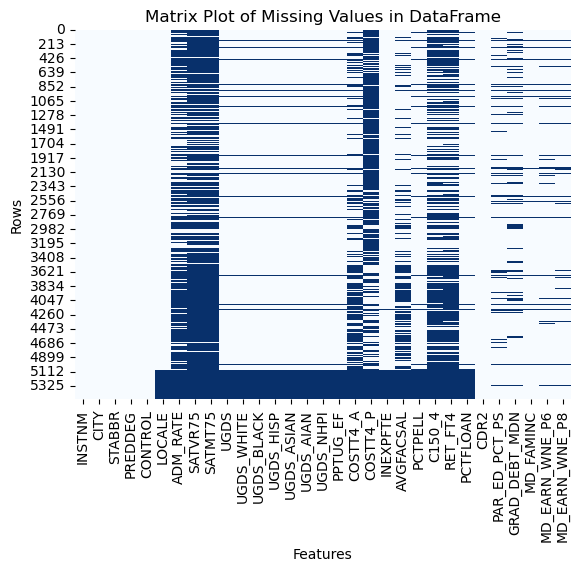

In [4]:
# Replace privacy suppressed values as null
df.replace('PS', np.nan, inplace=True)

# Generate heatmap of missingness within dataset
sns.heatmap(df.isnull(), cmap='Blues', cbar=False)

# Add title to plot
plt.title('Matrix Plot of Missing Values in DataFrame')

# Add x-axis label to plot
plt.xlabel('Features')

# Add y-axis label to plot
plt.ylabel('Rows')

# Save figure in output path
plt.savefig(os.path.join(output_path,"missingness_matrix.png"))

# Show plot
plt.show()

In [5]:
# Define a list of variables to calculate the proportion missing (appear to have majority missing)
variables = ['ADM_RATE','SATVR75','SATMT75','COSTT4_A','COSTT4_P','AVGFACSAL','C150_4','RET_FT4']

# Loop through the list of variables
for variable in variables:
    
    # Calculate the number of missing observations
    missing_count = df[variable].isnull().sum()
    
    # Calculate the proportion of missing observations
    proportion_missing = missing_count / df.shape[0]
    
    # Print the proportion of missing observations
    print(f"The proportion of {variable} that is missing is: {proportion_missing}")
    
# Drop variables with > 60% missing observations
df = df.drop(columns=['ADM_RATE','SATVR75','SATMT75','C150_4','RET_FT4'])

# Drop rows >= 5000 (extensive missingness across variables)
df = df.drop(df.index[df.index >= 5000])

The proportion of ADM_RATE that is missing is: 0.6746247060951347
The proportion of SATVR75 that is missing is: 0.8209441128594682
The proportion of SATMT75 that is missing is: 0.8209441128594682
The proportion of COSTT4_A that is missing is: 0.44239464640983905
The proportion of COSTT4_P that is missing is: 0.7276180141074335
The proportion of AVGFACSAL that is missing is: 0.3521432447097124
The proportion of C150_4 that is missing is: 0.6192801591607886
The proportion of RET_FT4 that is missing is: 0.652197504069452


In [6]:
# Replace null values of COSTT4_A with 0 when COSTT4_P is not null
df.loc[df['COSTT4_A'].isnull() & df['COSTT4_P'].notnull(), 'COSTT4_A'] = 0

# Replace null values of COSTT4_P with 0 when COSTT4_A is not null
df.loc[df['COSTT4_P'].isnull() & df['COSTT4_A'].notnull(), 'COSTT4_P'] = 0

# Consolidate cost variables into a single measure
df['COST'] = df['COSTT4_A'] + df['COSTT4_P']

# Drop separate cost variables
df = df.drop(columns=['COSTT4_A','COSTT4_P'])

# Generate summary statistics for cost variable
df['COST'].describe()

count     4515.000000
mean     27674.661573
std      15763.688348
min       3714.000000
25%      16276.500000
50%      23314.000000
75%      33252.500000
max      86964.000000
Name: COST, dtype: float64

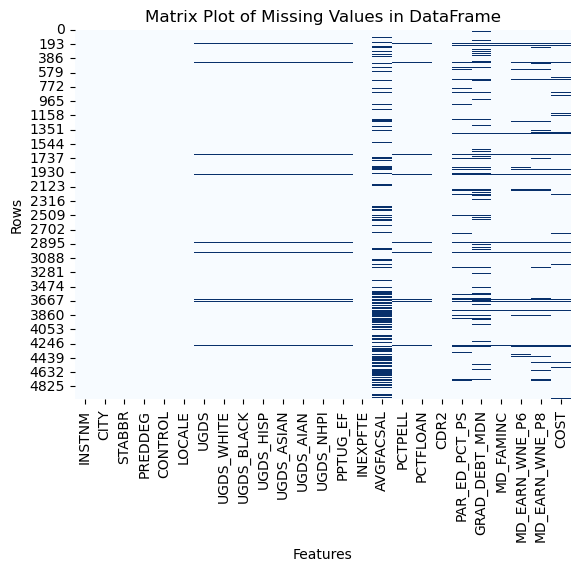

In [7]:
# Generate new heatmap of missingness within dataset
sns.heatmap(df.isnull(), cmap='Blues', cbar=False)

# Add title to plot
plt.title('Matrix Plot of Missing Values in DataFrame')

# Add x-axis label to plot
plt.xlabel('Features')

# Add y-axis label to plot
plt.ylabel('Rows')

# Save figure in output path
plt.savefig(os.path.join(output_path,"missingness_matrix_1.png"))

# Show plot
plt.show()

In [8]:
# Define imputer object with 100 iterations and random state 1680
imputer = IterativeImputer(max_iter=100, random_state=1680)

# Drop string columns from dataset
df = df.drop(columns=['INSTNM','CITY','STABBR'])

# Fit the imputer on the dataset and perform imputation
X_imputed = imputer.fit_transform(df)

# Transform imputed array back into a dataframe
df_imputed = pd.DataFrame(X_imputed,columns=df.columns)

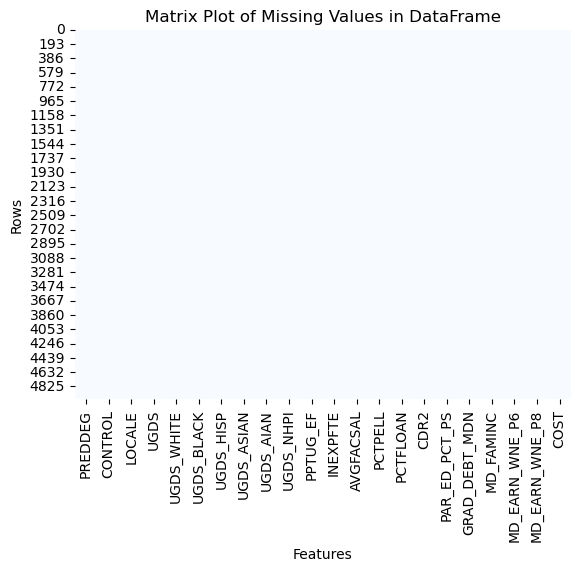

In [9]:
# Generate new heatmap of missingness within dataset
sns.heatmap(df_imputed.isnull(), cmap='Blues', cbar=False)

# Add title to plot
plt.title('Matrix Plot of Missing Values in DataFrame')

# Add x-axis label to plot
plt.xlabel('Features')

# Add y-axis label to plot
plt.ylabel('Rows')

# Save figure in output path
plt.savefig(os.path.join(output_path,"missingness_matrix_2.png"))

# Show plot
plt.show()

In [10]:
# Save cleaned data
df_imputed.to_csv(os.path.join(file_path,'Most-Recent-Cohorts-Institution_cleaned.csv'),index=False)